# Orbital rotations

The orbital rotation is a fundamental operation in the simulation of fermions. This page discusses orbital rotations and their properties.

## Definition of orbital rotation

An orbital rotation is described by an $N \times N$ unitary matrix $\mathbf{U}$ (here $N$ is the number spatial orbitals), and we denote the corresponding operator as $\mathcal{U}$. This operator has the following action on the fermionic creation operators $\set{a^\dagger_{\sigma, i}}$:

$$
\begin{align*}
    \mathcal{U} a^\dagger_{\sigma, i} \mathcal{U}^\dagger = \sum_j \mathbf{U}_{ji} a^\dagger_{\sigma, j}.
\end{align*}
$$

That is, $a^\dagger_{\sigma, i}$ is mapped to a new operator $b^\dagger_{\sigma, i}$ where $b^\dagger_{\sigma, i}$ is a linear combination of the operators $\set{a^\dagger_{\sigma, i}}$ with coefficients given by the $i$-th column of $\mathbf{U}$. The fact that $\mathbf{U}$ is unitary can be used, together with the fermionic anticommutation relations, to show that the $\set{b^\dagger_{\sigma, i}}$ also satisfy the fermionic anticommutation relations. Thus, the $b^\dagger_{\sigma, i}$ are creation operators in a rotated basis of orbitals.

### Explicit expression

It is a theorem that $\mathcal{U}$ can be written explicitly as

$$
\begin{align*}
    \mathcal{U} = \prod_{\sigma}
    \exp\left[\sum_{ij} \log\left(\mathbf{U}\right)_{ij} a^\dagger_{\sigma, i} a_{\sigma, j}\right]
\end{align*}.
$$
Sometimes, it is useful to specify the orbital rotation via the antihermitian matrix $\mathbf{K} = \log(\mathbf{U})$ rather than $\mathbf{U}$ itself. However, ffsim generally represents orbital rotations using the unitary matrix $\mathbf{U}$.

### Homomorphism property

The mapping $\mathbf{U} \mapsto \mathcal{U}$ satisfies the important homomorphism property:

$$
\begin{align*}
    \mathbf{U}^\dagger &\mapsto \mathcal{U}^\dagger, \\
    \mathbf{U}_1 \mathbf{U}_2 &\mapsto \mathcal{U}_1 \mathcal{U}_2
\end{align*}
$$

for any unitary matrices $\mathbf{U}$, $\mathbf{U}_1$, and $\mathbf{U}_2$.

### Independent orbital rotations for spin-up and spin-down

The definitions given above assume that the same orbital rotation applies to both the spin-up and spin-down orbitals. However, it is possible for each spin sector to have an independent orbital rotation, in which case a pair of unitary matrices $(\mathbf{U}^\alpha, \mathbf{U}^\beta)$ needs to be specified. Letting $\mathbf{K}^\sigma = \log(\mathbf{U}^\sigma)$, the definitions above then become

$$
\begin{align*}
    \mathcal{U} a^\dagger_{\sigma, i} \mathcal{U}^\dagger &= \sum_j \mathbf{U}^{\sigma}_{ji} a^\dagger_{\sigma, j}, \\
    \mathcal{U} &= \prod_{\sigma}
    \exp\left[\sum_{ij} \log\left(\mathbf{U}^{\sigma}\right)_{ij} a^\dagger_{\sigma, i} a_{\sigma, j}\right].
\end{align*}
$$

## Application to time evolution by a quadratic Hamiltonian

A quadratic Hamiltonian is an operator of the form (here we restrict the definition to Hamiltonians with particle number and spin Z symmetry)

$$
    \mathcal{M} = \sum_{\sigma, ij} \mathbf{M}_{ij} a^\dagger_{\sigma, i} a_{\sigma, j}
$$

where $\mathbf{M}$ is a Hermitian matrix. Time evolution by this Hamiltonian is given by the operator $e^{-i \mathcal{M} t}$, where $t$ is the evolution time. Orbital rotations can be used to implement time evolution by a quadratic Hamiltonian using two different methods.

### Method 1: Diagonalize the quadratic Hamiltonian

A quadratic Hamiltonian can always be rewritten as

$$
    \mathcal{M} = \mathcal{U} \left(\sum_{\sigma, i} \lambda_i n_{\sigma, i}\right)\mathcal{U}^\dagger
$$

where the $\set{\lambda_i}$ are real numbers called orbital energies, $\mathcal{U}$ is an orbital rotation, and $n_{\sigma, i} = a^\dagger_{\sigma, i} a_{\sigma, i}$ is the occupation number operator. The $\set{\lambda_i}$ and the unitary matrix $\mathbf{U}$ describing the orbital rotation are obtained from an eigendecomposition of $\mathbf{M}$:

$$
    \mathbf{M}_{ij} = \sum_k \lambda_k \mathbf{U}_{ik} \mathbf{U}_{jk}^*.
$$

Time evolution by $\mathcal{M}$ can be implemented with the following steps:

- Compute the orbital energies $\set{\lambda_i}$ and the orbital rotation matrix $\mathbf{U}$ by performing an eigendecomposition of $\mathbf{M}$.
- Perform the orbital rotation $\mathcal{U}^\dagger$, which corresponds to the matrix $\mathbf{U}^\dagger$.
- Perform time evolution by the operator $\sum_{\sigma, i} \lambda_i n_{\sigma, i}$.
- Perform the orbital rotation $\mathcal{U}^\dagger$, which corresponds to the matrix $\mathbf{U}$.

### Method 2: Implement directly as an orbital rotation

Reviewing the [definition](#definition-of-orbital-rotation) of an orbital rotation, we can see that the time evolution operator $e^{-i \mathcal{M} t}$ is itself an orbital rotation defined by $\mathbf{K} = -i \mathbf{M} t$, or $\mathbf{U} = e^{-i \mathbf{M} t}$. Thus, the time evolution operator can be implemented directly as an orbital rotation.

The following code cell demonstrates the equivalence of the two methods by applying them to a randomly generated state vector and checking that the result is the same in both cases.

In [1]:
import numpy as np
import scipy.linalg

import ffsim

rng = np.random.default_rng(12345)
norb = 6
nelec = (3, 3)

# Generate a random Hermitian matrix M to represent the quadratic Hamiltonian
mat = ffsim.random.random_hermitian(norb, seed=rng)

# Generate a random state vector and set the evolution time
vec = ffsim.random.random_state_vector(ffsim.dim(norb, nelec), seed=rng)
time = 1.0

# Apply time evolution via diagonalization
eigs, orbital_rotation = scipy.linalg.eigh(mat)
result1 = ffsim.apply_num_op_sum_evolution(
    vec, eigs, time=time, norb=norb, nelec=nelec, orbital_rotation=orbital_rotation
)

# Apply time evolution directly as an orbital rotation
evolution_mat = scipy.linalg.expm(-1j * time * mat)
result2 = ffsim.apply_orbital_rotation(vec, evolution_mat, norb=norb, nelec=nelec)

# Check that the results match
np.testing.assert_allclose(result1, result2)

## Quantum circuit implementation

An orbital rotation can be implemented as a quantum circuit by decomposing it into [Givens rotations](../api/ffsim.rst#ffsim.apply_givens_rotation). Under the [Jordan-Wigner transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation), the circuit can be implemented as a dense brickwork pattern of two-qubit rotations, followed by a single layer of single-qubit phase gates. The following code cell constructs and displays a Qiskit circuit for implementing an orbital rotation. Notice that the circuit consists of two independent sub-circuits acting on each spin sector.

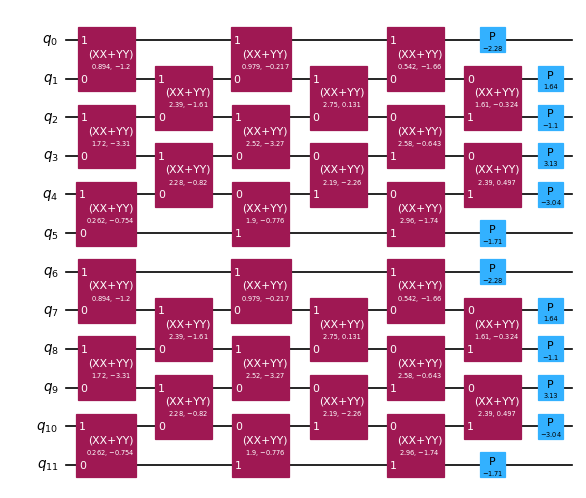

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister

norb = 6
nelec = (3, 3)

# Generate a random orbital rotation
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)

# Create a quantum circuit that implements this orbital rotation
qubits = QuantumRegister(2 * norb, name="q")
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.OrbitalRotationJW(norb, orbital_rotation), qubits)

# Decompose the orbital rotation into basic gates before drawing
circuit.decompose().draw("mpl", scale=0.6)

When an orbital rotation is applied to a single electronic configuration (in the qubit picture, a computational basis state), the quantum circuit implementation can be optimized to use fewer gates, resulting in a "diamond" pattern of gates rather than a dense "brickwork" pattern. For additional information, see [this paper](https://arxiv.org/abs/1711.05395).

The following code cell constructs and displays an example of the optimized circuit.

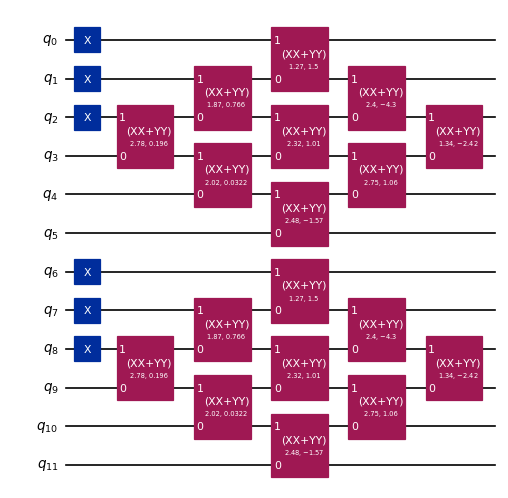

In [3]:
# Create a quantum circuit that applies an orbital rotation to the Hartree-Fock state
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.OrbitalRotationJW(norb, orbital_rotation), qubits)

# Optimize the orbital rotation circuit
circuit = ffsim.qiskit.PRE_INIT.run(circuit)

# Decompose the orbital rotation into basic gates before drawing
circuit.decompose().draw("mpl", scale=0.6)